# Bibliotek

In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import re

# Funksjoner

In [234]:
def calculate_chlorophyll_a(reflectance_data):
    a = 25.28
    b = 14.85
    c = -15.18
    
    # Extract reflectance values at the specific wavelengths
    Rrs_709 = reflectance_data.loc[reflectance_data['lambda'] == 709, 'reflectance'].values
    Rrs_665 = reflectance_data.loc[reflectance_data['lambda'] == 665, 'reflectance'].values

    # Ensure we have the reflectance values
    if Rrs_709.size > 0 and Rrs_665.size > 0:
        Rrs_709_value = Rrs_709[0]
        Rrs_665_value = Rrs_665[0]
        
        # Calculate Chl-a using the given empirical formula
        Chl_a = a * (Rrs_709_value / Rrs_665_value) ** 2 + b * (Rrs_709_value / Rrs_665_value) + c
        return Chl_a
    else:
        print("Reflectance values for 709 nm or 665 nm are not available.")
        return None

def parse_uvspec_output(filename):
    
    data = np.loadtxt(filename)
    data = pd.DataFrame(data, columns=['lambda', 'edir', 'edn', 'eup' , 'uavgdir', 'uavgdn', 'uavgup'])
    data['reflectance'] = data['edn'] / data['eup']

    return data


def parse_uvspec_output_umu(filename):
    """
    Parse the uvspec output for the specified format with umu data for each wavelength
    and return the data as a pandas DataFrame.

    Parameters:
    - filename: Path to the uvspec output file.

    Returns:
    - df: A pandas DataFrame containing the parsed data.
    """
    data = {
        'lambda': [],
        'edir': [],
        'edn': [],
        'eup': [],
        'uavgdir': [],
        'uavgdn': [],
        'uavgup': [],
        'umu_data': []
    }
    
    current_lambda = None
    umu_data = {}

    with open(filename, 'r') as file:
        lines = file.readlines()
        
        for line in lines:
            parts = line.strip().split()

            if not parts:
                continue

            if len(parts) == 7:
                # Wavelength block
                if current_lambda is not None:
                    data['umu_data'].append(umu_data)
                current_lambda = float(parts[0])
                data['lambda'].append(current_lambda)
                data['edir'].append(float(parts[1]))
                data['edn'].append(float(parts[2]))
                data['eup'].append(float(parts[3]))
                data['uavgdir'].append(float(parts[4]))
                data['uavgdn'].append(float(parts[5]))
                data['uavgup'].append(float(parts[6]))
                umu_data = {}

            elif len(parts) == 2 and current_lambda is not None:
                # umu and its corresponding values
                umu = float(parts[0])
                u0u = float(parts[1])
                umu_data[umu] = u0u

        if current_lambda is not None:
            data['umu_data'].append(umu_data)

    # Convert the parsed data into a pandas DataFrame
    df = pd.DataFrame({
        'lambda': data['lambda'],
        'edir': data['edir'],
        'edn': data['edn'],
        'eup': data['eup'],
        'uavgdir': data['uavgdir'],
        'uavgdn': data['uavgdn'],
        'uavgup': data['uavgup']
    })

    # Add umu columns dynamically
    for i, umu_dict in enumerate(data['umu_data']):
        for umu, u0u in umu_dict.items():
            df.at[i, f'umu({umu})'] = umu
            df.at[i, f'u0u({umu})'] = u0u

    return df



def parse_uvspec_output_umu_phi(filename):
    """
    Parse the uvspec output for the specified format with umu and phi data for each wavelength
    and return the data as a pandas DataFrame.

    Parameters:
    - filename: Path to the uvspec output file.

    Returns:
    - df: A pandas DataFrame containing the parsed data.
    """
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Initialize lists to store data
    wavelengths = []
    edir = []
    edn = []
    eup = []
    uavgdir = []
    uavgdn = []
    uavgup = []
    phi_values = []
    umu_data = []

    current_umu_data = []

    for line in lines:
        parts = line.strip().split()

        if len(parts) == 7:
            # Wavelength block
            if current_umu_data:
                umu_data.append(current_umu_data)
                current_umu_data = []
            wavelengths.append(float(parts[0]))
            edir.append(float(parts[1]))
            edn.append(float(parts[2]))
            eup.append(float(parts[3]))
            uavgdir.append(float(parts[4]))
            uavgdn.append(float(parts[5]))
            uavgup.append(float(parts[6]))

        elif len(parts) > 1 and all(part.replace('.', '', 1).isdigit() for part in parts):
            # Phi values
            phi_values = list(map(float, parts))

        elif len(parts) > 2:
            # Umu and its corresponding values
            umu = float(parts[0])
            u0u = float(parts[1])
            uu_values = list(map(float, parts[2:]))
            current_umu_data.append([umu, u0u] + uu_values)

    if current_umu_data:
        umu_data.append(current_umu_data)

    # Create DataFrame
    columns = ['lambda', 'edir', 'edn', 'eup', 'uavgdir', 'uavgdn', 'uavgup']
    for umu in umu_data[0]:
        columns.append(f'umu({umu[0]})')
        columns.append(f'u0u({umu[0]})')
        for phi in phi_values:
            columns.append(f'uu({umu[0]},{phi})')

    data = []
    for i in range(len(wavelengths)):
        row = [wavelengths[i], edir[i], edn[i], eup[i], uavgdir[i], uavgdn[i], uavgup[i]]
        for umu in umu_data[i]:
            row.extend(umu)
        data.append(row)

    # Ensure the number of columns matches the data
    max_columns = max(len(row) for row in data)
    for row in data:
        while len(row) < max_columns:
            row.append(None)

    # Adjust columns to match the maximum number of columns
    while len(columns) < max_columns:
        columns.append(f'unknown_col_{len(columns)}')

    df = pd.DataFrame(data, columns=columns)

    df = df.loc[:, ~df.columns.str.startswith('umu(')]

    return df



# Scenario 1 - Clean Sky

  Altitude      Chl-a
0      0 m  10.787587
1    120 m  10.823107
2   100 km  11.851941


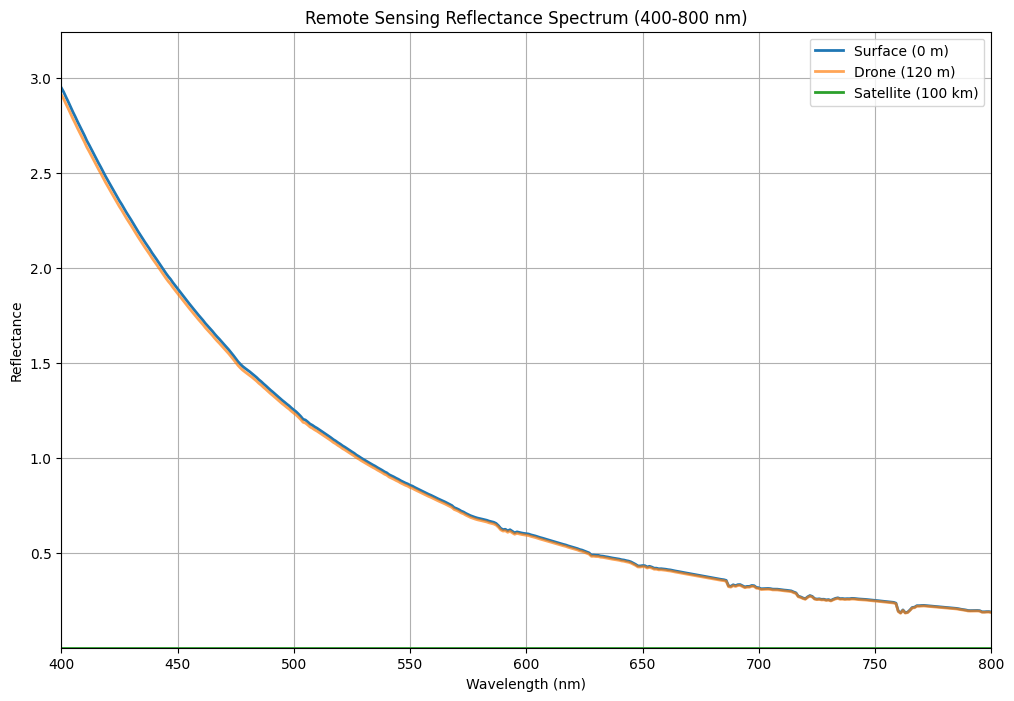

In [235]:
# load data
SC1_0m = parse_uvspec_output('Data/SC1_0m.OUT')

SC1_120m = parse_uvspec_output('Data/SC1_120m.OUT')

SC1_TOA = parse_uvspec_output('Data/SC1_TOA.OUT')


# Calculate Chl-a for each dataset
chl_a_0m = calculate_chlorophyll_a(SC1_0m)
chl_a_120m = calculate_chlorophyll_a(SC1_120m)
chl_a_TOA = calculate_chlorophyll_a(SC1_TOA)

chl_df = pd.DataFrame({
    'Altitude': ['0 m', '120 m', '100 km'],
    'Chl-a': [chl_a_0m, chl_a_120m, chl_a_TOA]
})

print(chl_df)

# Plot reflectance spectra
plt.figure(figsize=(12, 8))
plt.plot(SC1_0m['lambda'], SC1_0m['reflectance'], label='Surface (0 m)', linewidth=2)
plt.plot(SC1_120m['lambda'], SC1_120m['reflectance'], label='Drone (120 m)' , linewidth=2 , alpha=0.7)
plt.plot(SC1_TOA['lambda'], SC1_TOA['reflectance'], label='Satellite (100 km)' , linewidth=2)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Remote Sensing Reflectance Spectrum (400-800 nm)')
plt.legend()

plt.xlim(400, 800)
plt.ylim(
    min(SC1_0m['reflectance'].min(), SC1_120m['reflectance'].min(), SC1_TOA['reflectance'].min())*0.9,
    max(SC1_0m['reflectance'].max(), SC1_120m['reflectance'].max(), SC1_TOA['reflectance'].max()) * 1.1
)
plt.grid(True)
plt.show()

# Scenario 2 - Clean Sky

In [237]:
SC2_0m = parse_uvspec_output_umu_phi('Data/SC2_0m.OUT')
test= parse_uvspec_output_umu_phi('Data/test.OUT') # test the function with 4 phi values and 10 umu values

print(test.head())

   lambda      edir       edn       eup   uavgdir    uavgdn    uavgup  \
0   400.0  578.8991  242.0934  82.09926  74.82574  48.24168  13.06650   
1   401.0  579.6443  239.8485  81.94929  74.92207  47.87984  13.04263   
2   402.0  603.3866  246.4703  84.98569  77.99088  49.31004  13.52589   
3   403.0  571.3987  230.5653  80.19640  73.85627  46.22392  12.76365   
4   404.0  614.8812  244.7882  85.96695  79.47662  49.18543  13.68206   

    u0u(0.1)  uu(0.1,0.0)  uu(0.1,30.0)  ...   u0u(0.9)  uu(0.9,0.0)  \
0  26.133005    26.133005     26.133005  ...  26.133005    26.133005   
1  26.085266    26.085266     26.085266  ...  26.085266    26.085266   
2  27.051785    27.051785     27.051785  ...  27.051785    27.051785   
3  25.527308    25.527308     25.527308  ...  25.527308    25.527308   
4  27.364128    27.364128     27.364128  ...  27.364128    27.364128   

   uu(0.9,30.0)  uu(0.9,60.0)  uu(0.9,90.0)   u0u(1.0)  uu(1.0,0.0)  \
0     26.133005     26.133005     26.133005  26.133005   

# Scenario 3 - Oceanic Aerosols

# Scenario 4 - Adjacency Effects